# Install openai-agents SDK

In [ ]:
!pip install -Uq openai-agents

# Make your Notebook capable of running asynchronous functions.
Both Jupyter notebooks and Python’s asyncio library utilize event loops, but they serve different purposes and can sometimes interfere with each other.

The nest_asyncio library allows the existing event loop to accept nested event loops, enabling asyncio code to run within environments that already have an event loop, such as Jupyter notebooks.

In summary, both Jupyter notebooks and Python’s asyncio library utilize event loops to manage asynchronous operations. When working within Jupyter notebooks, it’s essential to be aware of the existing event loop to effectively run asyncio code without conflicts.

In [ ]:
import nest_asyncio
nest_asyncio.apply()

# Config

In [ ]:
from agents import (
    AsyncOpenAI,
    OpenAIChatCompletionsModel
)
from google.colab import userdata


In [ ]:
gemini_api_key = userdata.get("GEMINI_API_KEY")


# Check if the API key is present; if not, raise an error
if not gemini_api_key:
    raise ValueError("GEMINI_API_KEY is not set. Please ensure it is defined in your .env file.")

#Reference: https://ai.google.dev/gemini-api/docs/openai
external_client = AsyncOpenAI(
    api_key=gemini_api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
)

model = OpenAIChatCompletionsModel(
    model="gemini-2.0-flash",
    openai_client=external_client
)

In [ ]:
from agents import set_default_openai_client, set_tracing_disabled
set_default_openai_client(external_client)
set_tracing_disabled(True)

# Workflow: Orchestrator-workers

In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

[Learning Reference](https://www.anthropic.com/engineering/building-effective-agents)

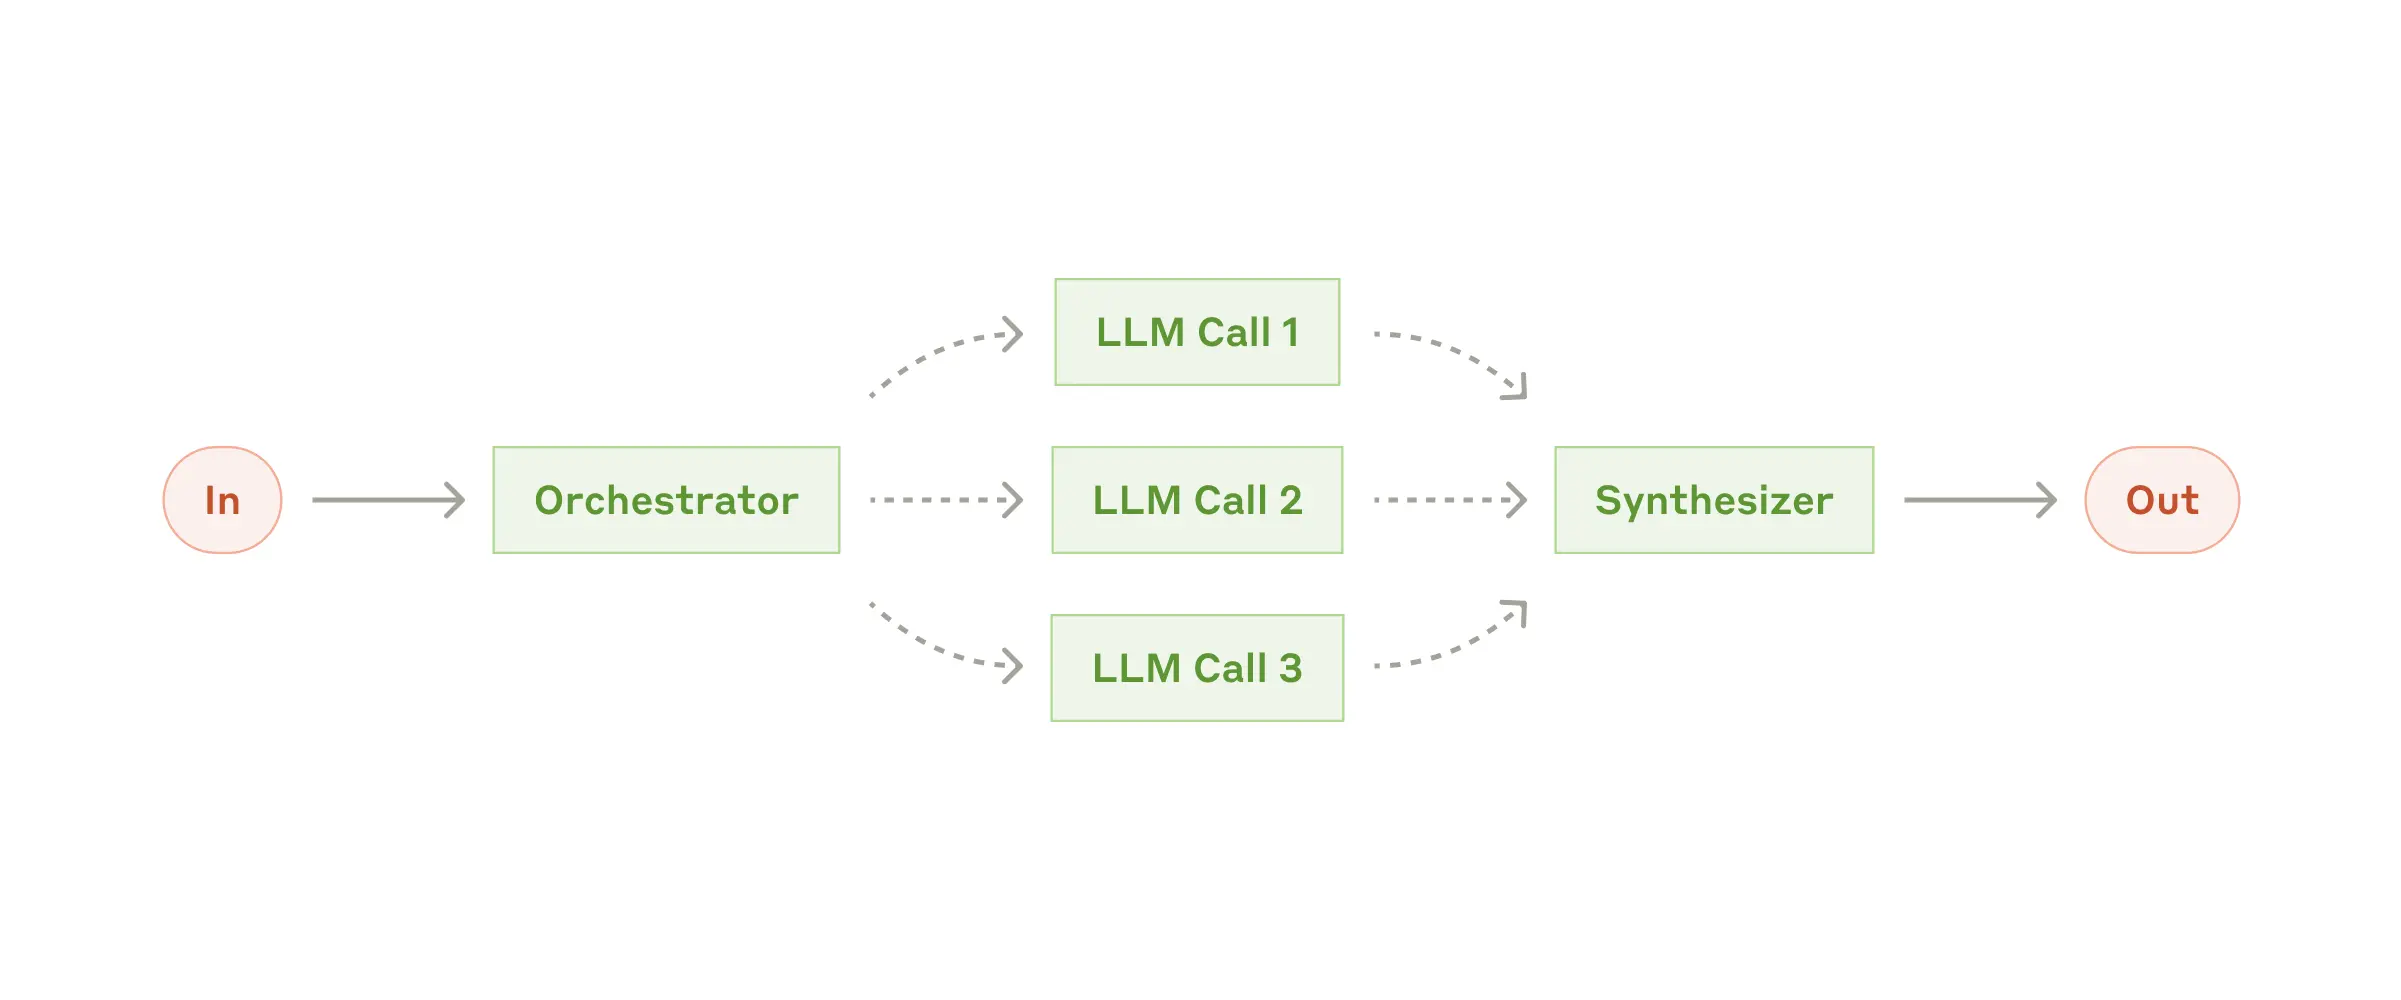

In [ ]:
import asyncio
from agents import Agent, ItemHelpers, MessageOutputItem, Runner

In [71]:
spanish_agent = Agent(
    name="spanish_agent",
    instructions="You translate the user's message to Spanish",
    handoff_description="An english to spanish translator",
    model=model
)

french_agent = Agent(
    name="french_agent",
    instructions="You translate the user's message to French",
    handoff_description="An english to french translator",
    model=model
)

italian_agent = Agent(
    name="italian_agent",
    instructions="You translate the user's message to Italian",
    handoff_description="An english to italian translator",
    model=model
)

orchestrator_agent = Agent(
    name="orchestrator_agent",
    instructions=(
        "You are a translation agent. You use the tools given to you to translate."
        "If asked for multiple translations, you call the relevant tools in order."
        "You never translate on your own, you always use the provided tools."
    ),
    tools=[
        spanish_agent.as_tool(
            tool_name="translate_to_spanish",
            tool_description="Translate the user's message to Spanish",
        ),
        french_agent.as_tool(
            tool_name="translate_to_french",
            tool_description="Translate the user's message to French",
        ),
        italian_agent.as_tool(
            tool_name="translate_to_italian",
            tool_description="Translate the user's message to Italian",
        ),
    ],
    model=model
)

synthesizer_agent = Agent(
    name="synthesizer_agent",
    instructions="You inspect translations, correct them if needed, and produce a final concatenated response. Always return the final response in with properly formatted translations.",
    model=model
)


async def main():
    msg = input("Hi! What would you like translated, and to which languages? ")

    # Run the entire orchestration in a single trace
    orchestrator_result = await Runner.run(orchestrator_agent, msg)

    for item in orchestrator_result.new_items:
        if isinstance(item, MessageOutputItem):
            text = ItemHelpers.text_message_output(item)
            if text:
                print(f"  - Translation step: {text}")

    synthesizer_result = await Runner.run(
        synthesizer_agent,
         (orchestrator_result.to_input_list() + [{"role": "user", 'content': f'pick best translation done for these {msg}' }])
    )

    print(f"\n\nFinal response:\n{synthesizer_result.final_output}")

    return synthesizer_result, orchestrator_result

In [73]:
synth_result, orch_result = asyncio.run(main())

Hi! What would you like translated, and to which languages? hello in spanish and french
  - Translation step: Hola.
Bonjour !



Final response:
Both translations are accurate and common. "Hola" is the standard greeting in Spanish, and "Bonjour !" is a very common and appropriate greeting in French. I don't have a basis to say one is definitively better than the other in this context.



#### Inspect the results

In [74]:
orch_result.to_input_list()

[{'content': 'hello in spanish and french', 'role': 'user'},
 {'id': '__fake_id__',
  'arguments': '{"input":"hello"}',
  'call_id': '',
  'name': 'translate_to_spanish',
  'type': 'function_call'},
 {'id': '__fake_id__',
  'arguments': '{"input":"hello"}',
  'call_id': '',
  'name': 'translate_to_french',
  'type': 'function_call'},
 {'call_id': '', 'output': 'Hola.\n', 'type': 'function_call_output'},
 {'call_id': '', 'output': 'Bonjour !\n', 'type': 'function_call_output'},
 {'id': '__fake_id__',
  'content': [{'annotations': [],
    'text': 'Hola.\nBonjour !\n',
    'type': 'output_text'}],
  'role': 'assistant',
  'status': 'completed',
  'type': 'message'}]

In [76]:
synth_result.final_output

'Both translations are accurate and common. "Hola" is the standard greeting in Spanish, and "Bonjour !" is a very common and appropriate greeting in French. I don\'t have a basis to say one is definitively better than the other in this context.\n'